In [2]:
import torch
import IPython.display as ipd

In [2]:
model_dict = {
    (5,8,'base'): '0513_173505_baseline_sr8_d3_5db.model',
    (5,8,'prop'): '0513_221509ratio_sr32_d6_5db.model',
    (5,16,'base'): '0512_221229_baseline_sr24_d3_5db.model',
    (5,16,'prop'): '0513_222859ratio_sr24_d6_5db.model',
    (5,24,'base'): '0512_133107_baseline_sr32_d3_5db.model',
    (5,24,'prop'): '0513_210109ratio_sr32_d6_5db.model',
    (5,32,'base'): '0512_133107_baseline_sr32_d3_5db.model',
    (5,32,'prop'): '0512_135150ratio_sr32_d6.model',
    (5,40,'base'): '0512_221521_baseline_sr32_d3_5db.model',
    (5,40,'prop'): '0512_180611_sr40_d6_5db.model',
    
    (0,8,'base'): '0513_133044_baseline_sr32_d3_0db.model',
    (0,8,'prop'): '0511_131846_s16_d3.model',
    (0,16,'base'): '0513_173626_baseline_sr32_d3_0db.model',
    (0,16,'prop'): '0509_sr8_d3.model',
    (0,24,'base'): '0510_142628_baseline_sr32_d3.model',
    (0,24,'prop'): '0511_025544_sr32_d3.model',
    (0,32,'base'): '0510_142628_baseline_sr32_d3.model',
    (0,32,'prop'): '0510_184527ratio_sr32_d6.model',
    (0,40,'base'): '0513_012257_baseline_sr40_d3_0db.model',
    (0,40,'prop'): '0509_sr32_d6.model'
    
}



In [8]:
model_oldprop = torch.load('Final_Models/0513_230921ratio_sr32_d6_5db.model') 
model_oldbase = torch.load('Final_Models/0512_132951_baseline_sr24_d3_5db.model')
model_newprop = torch.load('Final_Models/0602_123426ratio_sr24_d6_5db.model')
model_newbase = torch.load('0606_214529_baseline_sr32_d3_5db.model')

/media/sdb1/hy17/venv/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'Prop_sr.Prop_Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
db = 5
br = 8
# md = 'base'
m_prop = model_dict[(db, br, 'prop')]
m_base = model_dict[(db, br, 'base')]

In [4]:
model1 = torch.load(m_prop)
model2 = torch.load(m_base)

/media/sdb1/hy17/venv/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'Prop.Prop_Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [10]:
def load_trim(wavpath, n, db=0, overlap=64):
    
    window = np.hamming(overlap*2) 
    window = np.concatenate((window[:overlap],np.ones(512-overlap*2),window[overlap:]))
    window = window.reshape(1,-1)
    window = window.astype(np.float32)
    
    try:
        c, cr = librosa.load(wavpath, sr = None)
        c /= np.std(c)
    except OSError:
        print('errorfile:',wavpath)
    
    n = n[len(n)//2:len(n)//2+len(c)]
    if db == 0:
        n = n/np.std(n)
    else:
        n = n/(np.std(n)*2)
    n /= max(abs(c))
    c /= max(abs(c))
    x = c + n
    
    c_l = []
    x_l = []
    
    for i in range(0, len(c), 512 - overlap):
        if i + 512 > len(c):
            break
        c_l.append(c[i:i+512])
        x_l.append(x[i:i+512])
    c_l = np.array(c_l)
    x_l = np.array(x_l)
    c = c[:len(c_l)*(512-overlap)+overlap]
    x = x[:len(c)]
    
    c_l = c_l * window
    x_l = x_l * window

    return c_l, c, x_l, x


def rebuild(output, overlap = 64):
    output = output.cpu()
    len_wav = len(output) * (512 - overlap) + overlap
    wave = torch.zeros(len_wav)
    for i in range(len(output)):
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i]       
    
    return wave

def SDR(s, sr): # input (50, 512), (50, 512)
    
    eps=1e-20
    s = s.cpu().data.numpy()
    sr = sr.cpu().data.numpy()
    sdr = 10*np.log10(np.sum(s**2)/(np.sum((s-sr)**2)+eps)+eps)
    
    return sdr

def SISDR(s,sr,  cuda = False):
    
    eps = 1e-20
    scale = torch.sum(sr * s, dim = 1) / torch.sum(s**2, dim = 1) 
    scale = scale.unsqueeze(dim = 1) # shape - [50,1]
    s = s * scale
    sisdr = torch.mean(10*torch.log10(torch.sum(s**2, dim = 1)/(torch.sum((s-sr)**2, dim=1)+eps)+eps))
    if cuda:
        return torch.mean(sisdr)
    else:
        return torch.mean(sisdr).cpu().data.numpy()
    
import collections
def entropy(arg):
    entropy = 0
    counter = collections.Counter(arg)
    sum_v = sum(counter.values())
    for value in counter.values():
        p = value / sum_v
        entropy += - np.log(p)*p
    return entropy


In [12]:
import IPython.display
import matplotlib.pyplot as plt
import librosa
import numpy as np

wavpath0 = '/media/sdc1/Data/timit-wav/test/dr5/mrws1/sx140.wav'
wavpath1 = '/media/sdc1/Data/timit-wav/test/dr1/faks0/sa1.wav'
wavpath2 = '/media/sdc1/Data/timit-wav/test/dr1/mreb0/sa2.wav'
wavpath3 = '/media/sdc1/Data/timit-wav/test/dr3/mkch0/sx28.wav'
wavpath4 = '/media/sdc1/Data/timit-wav/test/dr3/fkms0/sx50.wav'
wavpath5 = '/media/sdc1/Data/timit-wav/test/dr5/fjcs0/sx139.wav'
wavpath6 = '/media/sdc1/Data/timit-wav/test/dr4/fsem0/sx28.wav'
wavpath7 = '/media/sdc1/Data/timit-wav/test/dr4/mkcl0/sx191.wav'
wavpath8 = '/media/sdc1/Data/timit-wav/test/dr6/flnh0/sx134.wav'
wavpath9 = '/media/sdc1/Data/timit-wav/test/dr6/mesd0/sx12.wav'

path_name = [wavpath0, wavpath1, wavpath2,wavpath3,wavpath4,wavpath5,wavpath6,wavpath7,wavpath8,wavpath9]
# n_idx = [2, -1, -3, -4, 5, 1]

# idx = 4
names = ['birds', 'computerkeyboard', 'jungle', 'ocean', 'casino', 'eatingchips', 'machineguns',\
                 'cicadas', 'frogs', 'motorcycles']
i = 1
path = path_name[i]
noise_path = '/media/sdc1/Data/Duan/{}.wav'.format(names[i])
n, nr = librosa.load(noise_path, sr=None)
# tes, sr = librosa.load(wavpath5, sr=None)

db = 5
c_l, c, x_l, x = load_trim(path, n, db=db)

c_l = torch.Tensor(c_l)
c = torch.Tensor(c)
x_l = torch.Tensor(x_l)
#         x = torch.Tensor(x)


In [13]:
def generate_result(model, x_l):
    model.eval()
    s_h, n_h, prob_s, prob_n = model(x_l.cuda(),soft = False)
    rx = rebuild(s_h+n_h).cpu().data.numpy()
    rs = rebuild(s_h).cpu().data.numpy()
    
    return rs, rx

**Old Prop**

In [23]:
rs, rx = generate_result(model_oldprop, x_l)
ipd.Audio(rx/max(rx), rate = 16000)

In [24]:
ipd.Audio(rs/max(rs), rate = 16000)

**Old Base**

In [25]:
rs, rx = generate_result(model_oldbase, x_l)
ipd.Audio(rx/max(rx), rate = 16000)

In [26]:
ipd.Audio(rs/max(rs), rate = 16000)

**New Prop**

In [27]:
rs, rx = generate_result(model_newprop, x_l)
ipd.Audio(rx/max(rx), rate = 16000)

In [28]:
ipd.Audio(rs/max(rs), rate = 16000)

**New Base**

In [29]:
rs, rx = generate_result(model_newbase, x_l)
ipd.Audio(rx/max(rx), rate = 16000)

In [30]:
ipd.Audio(rs/max(rs), rate = 16000)

In [19]:
for i in range(len(audio_list)):
    librosa.output.write_wav(audio_name[i], audio_list[i], sr = 16000)

In [933]:
rx1 = rebuild(s_h1+n_h1).cpu().data.numpy()
rx2 = rebuild(s_h2+n_h2).cpu().data.numpy()
rs1 = rebuild(s_h1).cpu().data.numpy()
rs2 = rebuild(s_h2).cpu().data.numpy()


In [934]:
ipd.Audio(x/max(x), rate = 16000)
# librosa.output.write_wav('Results/0db_40kbps_proposed_mixture.wav', x/max(x), sr = 16000)

In [935]:
ipd.Audio(rx1/max(rx1), rate = 16000)
# librosa.output.write_wav('Results/0db_40kbps_proposed_mixture.wav', rx1/max(rx1), sr = 16000)

In [937]:
ipd.Audio(rx2/max(rx2), rate = 16000)
# librosa.output.write_wav('Results/16kbps_test.wav', rx2/max(rx2), sr = 16000)

In [819]:
# ipd.Audio(rx2/max(rx2), rate = 16000)
r = rx2/np.std(rx2)
r = r/max(abs(r))/1.1
librosa.output.write_wav('Results/std_baseline8kb.wav', r, sr = 16000)

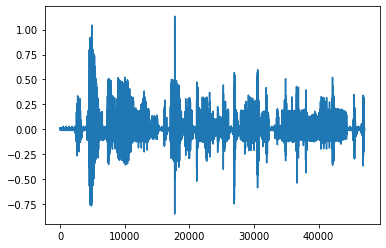

In [704]:
plt.plot(rx2)

In [497]:
# ipd.Audio(rs1/max(rs1), rate = 16000)
# librosa.output.write_wav('Results/0db_40kbps_proposed_speech.wav', rs1/max(rs1), sr = 16000)

In [487]:
# ipd.Audio(rs2/max(rs2), rate = 16000)
# librosa.output.write_wav('Results/0db_40kbps_baseline_speech.wav', rs2/max(rs2), sr = 16000)

## Plot

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [59]:
base_0_sp = [3.94, 6.10, 8.30, 8.42, 7.76]
base_0_mx = [5.64, 8.88, 13.17, 12.50, 12.34]

base_5_sp = [7.12, 9.58, 10.47, 10.67, 10.42]
base_5_mx = [7.36, 11.26, 13.60, 13.35, 13.03]


prop_0_sp = [4.15, 6.50, 11.24, 9.23, 9.40]
prop_0_mx = [7.64, 9.20, 14.72, 15.35, 16.37]

prop_5_sp = [9.28, 10.62, 10.98, 11.24, 11.27]
prop_5_mx = [10.70, 13.23, 14.42, 15.01, 15.08]

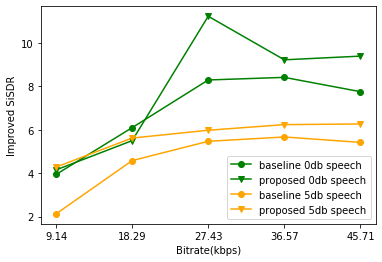

In [5]:
fig = plt
x_values = ['9.14', '18.29','27.43','36.57','45.71']
x_labels = 'Bitrate(kbps)'
fig.plot(base_0_sp, label='baseline 0db speech', color='green', marker='o')
fig.plot(prop_0_sp, label='proposed 0db speech', color='green', marker='v')
fig.plot(np.array(base_5_sp)-5, label='baseline 5db speech', color='orange', marker='o')
fig.plot(np.array(prop_5_sp)-5, label='proposed 5db speech', color='orange', marker='v')

fig.xlabel(x_labels)
fig.ylabel('Improved SiSDR')
plt.xticks([0, 1, 2, 3, 4], x_values)
fig.legend()
fig.show()

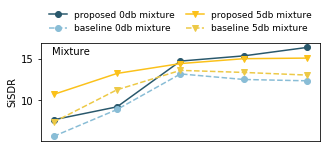

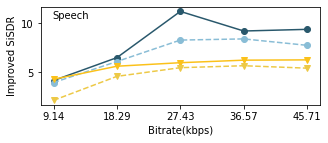

In [183]:
fig, ax = plt.subplots(figsize=(5, 1.8))

x_values = ['9.14', '18.29','27.43','36.57','45.71']
x_labels = 'Bitrate(kbps)'

ax.plot(prop_0_mx, label='proposed 0db mixture', color= '#29586c', marker='o')
ax.plot(base_0_mx, label='baseline 0db mixture', color= '#89bdd6', linestyle = 'dashed', marker='o')
ax.plot(np.array(prop_5_mx), label='proposed 5db mixture', color='#fbc11a', marker='v')
ax.plot(np.array(base_5_mx), label='baseline 5db mixture', color='#EDC946', linestyle ='dashed',marker='v')

ax.set(ylabel='SiSDR')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['']*len(x_values))
ax.text(0.04, .96, va='top', ha='left', s='Mixture', transform=ax.transAxes)

# hide x-axis
ax.tick_params(axis='x', which='major', top=False, bottom=False, length=0)
ax.tick_params(axis='x', which='minor', top=False, bottom=False, length=0)

plt.legend(loc='lower left', bbox_to_anchor =(0,1.02,1,0.2),
          frameon=False, mode="expand", ncol=2, fontsize=9)
# fig.savefig('Results/sisdr_top.pdf', pad_inches=0)
fig.savefig('Results/sisdr_top.pdf', bbox_inches='tight')
plt.show()

######

fig, ax = plt.subplots(figsize=(5, 1.8))

ax.plot(prop_0_sp, label='proposed 0db speech', color= '#29586c', marker='o')
ax.plot(base_0_sp, label='baseline 0db speech', color= '#89bdd6', linestyle = 'dashed', marker='o')
ax.plot(np.array(prop_5_sp)-5, label='proposed 5db speech', color='#fbc11a', marker='v')
ax.plot(np.array(base_5_sp)-5, label='baseline 5db speech', color='#EDC946', linestyle ='dashed',marker='v')

ax.text(0.04, .96, va='top', ha='left', s='Speech', transform=ax.transAxes)
ax.set(xlabel=x_labels, ylabel='Improved SiSDR')
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(x_values)

ax.set(ylabel='Improved SiSDR')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(x_values)
#ax.text(0.1,14.8, 'Mixture')

fig.savefig('Results/sisdr_bottom.pdf', bbox_inches='tight')
plt.show()

# ax2.legend(loc=4)

# fig2.show() 

# fig.savefig('Results/stoi.jpg')
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0 + box.height*0.1,
#                  box.width, box.height * 0.9])
# box = ax2.get_position()
# ax2.set_position([box.x0, box.y0,
#                 box.width, box.height * 0.9])
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0 ,
#                 box.width, box.height * 0.7])

# fig.savefig('Results/sisdr.pdf')
# plt.show()
# fig.show()
# bbox_to_anchor=(0.5, -0.05),

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

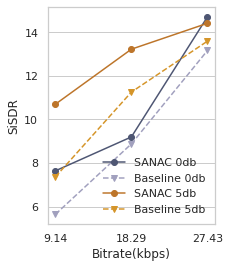

In [76]:
fig, ax = plt.subplots(figsize=(3,4))
ax.xaxis.grid() # vertical lines
# ax.linewidth: 1
x_values = ['9.14', '18.29','27.43']
x_labels = 'Bitrate(kbps)'
sns.set(style="whitegrid")
# ax.plot(prop_0_mx[:3], label='SANAC 0db', color= '#29586c', marker='o')
# ax.plot(base_0_mx[:3], label='Baseline 0db', color= '#89bdd6', linestyle = 'dashed', marker='v')
# ax.plot(np.array(prop_5_mx)[:3], label='SANAC 5db', color='#fbc11a', marker='o')
# ax.plot(np.array(base_5_mx)[:3], label='Baseline 5db', color='#EDC946', linestyle ='dashed',marker='v')

ax.plot(prop_0_mx[:3], label='SANAC 0db', color= '#29586c', marker='o')
ax.plot(base_0_mx[:3], label='Baseline 0db', color= '#89bdd6', linestyle = 'dashed', marker='v')
ax.plot(np.array(prop_5_mx)[:3], label='SANAC 5db', color='#fbc11a', marker='o')
ax.plot(np.array(base_5_mx)[:3], label='Baseline 5db', color='#EDC946', linestyle ='dashed',marker='v')


ax.set(ylabel='SiSDR')
ax.set(xlabel='Bitrate(kbps)')
ax.set_xticks([0, 1, 2])
# ax.set_xticklabels(['']*len(x_values))
ax.set_xticklabels(x_values)
# ax.text(0.04, .96, va='top', ha='left', s='Mixture', transform=ax.transAxes, fontsize=12 )

# # hide x-axis
# ax.tick_params(axis='x', which='major', top=False, bottom=False, length=0)
# ax.tick_params(axis='x', which='minor', top=False, bottom=False, length=0)

plt.legend(loc='lower right',frameon=False)
# fig.savefig('Results/sisdr_top.pdf', pad_inches=0)
fig.savefig('sisdr_left_34.pdf', bbox_inches='tight')
plt.show()

######

# fig, ax = plt.subplots(figsize=(5, 1.8))

# ax.plot(prop_0_sp, label='proposed 0db speech', color= '#29586c', marker='o')
# ax.plot(base_0_sp, label='baseline 0db speech', color= '#89bdd6', linestyle = 'dashed', marker='o')
# ax.plot(np.array(prop_5_sp)-5, label='proposed 5db speech', color='#fbc11a', marker='v')
# ax.plot(np.array(base_5_sp)-5, label='baseline 5db speech', color='#EDC946', linestyle ='dashed',marker='v')

# ax.text(0.04, .96, va='top', ha='left', s='Speech', transform=ax.transAxes)
# ax.set(xlabel=x_labels, ylabel='Improved SiSDR')
# ax.set_xticks([0,1,2,3,4])
# ax.set_xticklabels(x_values)

# ax.set(ylabel='Improved SiSDR')
# ax.set_xticks([0, 1, 2, 3, 4])
# ax.set_xticklabels(x_values)
# #ax.text(0.1,14.8, 'Mixture')

# fig.savefig('Results/sisdr_bottom.pdf', bbox_inches='tight')
# plt.show()

# ax2.legend(loc=4)

# fig2.show() 

# fig.savefig('Results/stoi.jpg')
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0 + box.height*0.1,
#                  box.width, box.height * 0.9])
# box = ax2.get_position()
# ax2.set_position([box.x0, box.y0,
#                 box.width, box.height * 0.9])
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0 ,
#                 box.width, box.height * 0.7])

# fig.savefig('Results/sisdr.pdf')
# plt.show()
# fig.show()
# bbox_to_anchor=(0.5, -0.05),

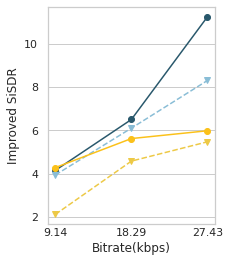

In [40]:
fig, ax = plt.subplots(figsize=(3,4))
ax.xaxis.grid() # h lines
x_values = ['9.14', '18.29','27.43']
x_labels = 'Bitrate(kbps)'

ax.plot(prop_0_sp[:3], label='proposed 0db', color= '#29586c', marker='o')
ax.plot(base_0_sp[:3], label='baseline 0db', color= '#89bdd6', linestyle = 'dashed', marker='v')
# ax.plot(np.array(prop_5_sp)[:3]-5, label='proposed 5db speech', color='#fbc11a', marker='o')
# ax.plot(np.array(base_5_sp)[:3]-5, label='baseline 5db speech', color='#EDC946', linestyle ='dashed',marker='v')
ax.plot(np.array(prop_5_sp)[:3]-5, label='proposed 5db', color='#fbc11a', marker='o')
ax.plot(np.array(base_5_sp)[:3]-5, label='baseline 5db', color='#EDC946', linestyle ='dashed',marker='v')

ax.set(ylabel='Improved SiSDR')
ax.set(xlabel=x_labels)
ax.set_xticks([0, 1, 2])
# ax.set_xticklabels(['']*len(x_values))
ax.set_xticklabels(x_values)
# ax.text(0.04, .96, va='top', ha='left', s='Speech', transform=ax.transAxes, fontsize = 12)

# hide x-axis
ax.tick_params(axis='x', which='major', top=True, bottom=True, length=0)
ax.tick_params(axis='x', which='minor', top=True, bottom=True, length=0)

# plt.legend(loc='lower right',frameon=False)
# fig.savefig('Results/sisdr_top.pdf', pad_inches=0)
fig.savefig('sisdr_right_34.pdf', bbox_inches='tight')
plt.show()

######

# fig, ax = plt.subplots(figsize=(5, 1.8))

# ax.plot(prop_0_sp, label='proposed 0db speech', color= '#29586c', marker='o')
# ax.plot(base_0_sp, label='baseline 0db speech', color= '#89bdd6', linestyle = 'dashed', marker='o')
# ax.plot(np.array(prop_5_sp)-5, label='proposed 5db speech', color='#fbc11a', marker='v')
# ax.plot(np.array(base_5_sp)-5, label='baseline 5db speech', color='#EDC946', linestyle ='dashed',marker='v')

# ax.text(0.04, .96, va='top', ha='left', s='Speech', transform=ax.transAxes)
# ax.set(xlabel=x_labels, ylabel='Improved SiSDR')
# ax.set_xticks([0,1,2,3,4])
# ax.set_xticklabels(x_values)

# ax.set(ylabel='Improved SiSDR')
# ax.set_xticks([0, 1, 2, 3, 4])
# ax.set_xticklabels(x_values)
# #ax.text(0.1,14.8, 'Mixture')

# fig.savefig('Results/sisdr_bottom.pdf', bbox_inches='tight')
# plt.show()

# ax2.legend(loc=4)

# fig2.show() 

# fig.savefig('Results/stoi.jpg')
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0 + box.height*0.1,
#                  box.width, box.height * 0.9])
# box = ax2.get_position()
# ax2.set_position([box.x0, box.y0,
#                 box.width, box.height * 0.9])
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0 ,
#                 box.width, box.height * 0.7])

# fig.savefig('Results/sisdr.pdf')
# plt.show()
# fig.show()
# bbox_to_anchor=(0.5, -0.05),

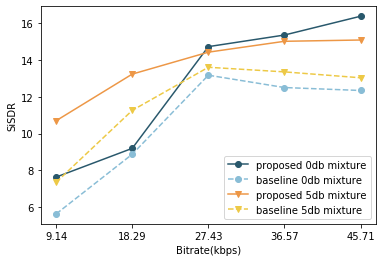

In [13]:
fig = plt
x_values = ['9.14', '18.29','27.43','36.57','45.71']
x_labels = 'Bitrate(kbps)'


fig.plot(prop_0_mx, label='proposed 0db mixture', color= '#29586c', marker='o')
fig.plot(base_0_mx, label='baseline 0db mixture', color= '#89bdd6', linestyle = 'dashed', marker='o')
fig.plot(np.array(prop_5_mx)-5, label='proposed 5db mixture', color='#FC9241', marker='v')
fig.plot(np.array(base_5_mx)-5, label='baseline 5db mixture', color='#FBD64A', linestyle ='dashed',marker='v')
fig.xlabel(x_labels)
fig.ylabel('Improved SiSDR')
plt.xticks([0, 1, 2, 3, 4], x_values)
fig.legend()
fig.show()

# blue '#29586c', '#89bdd6'
# yellow '#fbc11a', '#fade98'

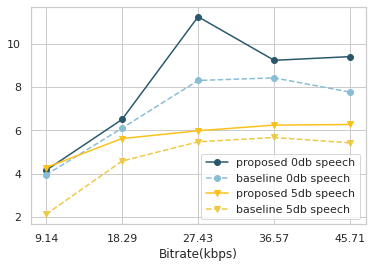

In [38]:
fig = plt
x_values = ['9.14', '18.29','27.43','36.57','45.71']
x_labels = 'Bitrate(kbps)'


fig.plot(prop_0_sp, label='proposed 0db speech', color= '#29586c', marker='o')
fig.plot(base_0_sp, label='baseline 0db speech', color= '#89bdd6', linestyle = 'dashed', marker='o')
fig.plot(np.array(prop_5_sp)-5, label='proposed 5db speech', color='#fbc11a', marker='v')
fig.plot(np.array(base_5_sp)-5, label='baseline 5db speech', color='#EDC946', linestyle ='dashed',marker='v')
fig.xlabel(x_labels)
# fig.ylabel('Improved SiSDR')
plt.xticks([0, 1, 2, 3, 4], x_values)
fig.legend()
fig.show()

# blue '#29586c', '#89bdd6'
# yellow '#fbc11a', '#fade98'

### Json

In [734]:

# for b in [8, 16, 24]:
#     t = 0
#     for i in range(10):
#         t += 1
#         AB = ['{}kbps_prop_{}_Prop.wav'.format(b,i), '{}kbps_prop_{}_Base.wav'.format(b,i)]
#         l = list(np.random.permutation(AB))
#         X = '{}kbps_prop_{}_X.wav'.format(b,i)
#         out = \
#         '{\n\
#         \t"Name":"Test'+str(t)+'",\n\
#         \t"TestID":"'+str(t)+'",\n\
#         \t"Files":{\n\
#         \t\t"A": "audio/'+l[0]+'",\n\
#         \t\t"B": "audio/'+l[1]+'",\n\
#         \t\t"X": "audio/'+X+'"\n\
#         \t}\n\
#         },'
#         outpath = 'Results/{}br_testset.txt'.format(b)
#         with open(outpath, 'a') as the_file:
#             the_file.write(out+'\n')

## AB boxplot

In [62]:
import matplotlib.pyplot as plt

In [63]:
low_truth = ['B','A','A','B','B','A','A','A','A','B']
medium_truth = ['B','A','B','A','B','B','A','B','A','B']
high_truth = ['B','B','A','B','A','B','B','A','A','B']

haici, minje, ky, db, aw, sw, kai, sn

In [64]:
low_test = [["B","A","A","B","B","A","A","A","A","B"],\
            ["B","A","A","B","B","A","A","A","A","B"],\
            ['B','A','A','B','B','A','A','A','A','B'],\
            ["B","A","A","B","B","A","A","B","A","B"],\
            ["B","A","A","B","B","A","A","A","A","B"],\
            ["B","A","B","B","B","B","A","A","A","B"],\
            ["B","A","A","B","B","A","A","A","A","B"],\
            ["B","A","A","B","B","A","A","A","A","B"]
           ]

In [65]:
medium_test = [["B","A","B","B","A","B","B","B","A","B"],\
               ["B","A","B","A","B","A","A","B","A","B"],\
               ["A","A","B","A","A","B","A","B","A","B"],\
               ["A","B","B","A","B","B","A",'B',"A","B"],\
               ["B","A","B","A","B","B","A","B","A","B"],\
               ["B","B","B","A","B","A","B","B","A","B"],\
               ["B","A","B","B","B","A","B","B","A","B"],\
               ["B","A","B","A","B","A","B","B","A","B"]
              ]

In [66]:
high_test = [["B","B","A","A","B","A","A","A","A","B"],\
             ["B","A","A","A","B","B","A","A","A","A"],\
             ["A","B","B","B","A","A","A","A","A","B"],\
             ["A","A","A","A","B","B","A","B","A","A"],\
             ["A","B","A","B","B","B","A","A","A","B"],\
             ["A","A","A","B","B","A","A","A","A","B"], \
             ["B","B","A","A","B","A","A","A","A","B"],\
             ["B","B","A","B","A","A","A","A","B","B"]
    ]
high_truth = ['B','B','A','B','A','B','B','A','A','B']
names = ['birds', 'computerkeyboard', 'jungle', 'ocean', 'casino', 'eatingchips', 'machineguns',\
                 'cicadas', 'frogs', 'motorcycles']

In [67]:
low_p = []
low_b = []
mid_p = []
mid_b = []
high_p = []
high_b = []

for test in low_test:
    p = 0
    for i in range(len(test)):
        if test[i] == low_truth[i]:
            p+=1
    low_p.append(p)
    low_b.append(10-p)
    
for test in medium_test:
    p = 0
    for i in range(len(test)):
        if test[i] == medium_truth[i]:
            p+=1
    mid_p.append(p)
    mid_b.append(10-p)
    
for test in high_test:
    p = 0
    for i in range(len(test)):
        if test[i] == high_truth[i]:
            p+=1
    high_p.append(p)
    high_b.append(10-p)
            

In [68]:
high_noise = np.zeros(10)
for test in high_test:
    for i in range(len(test)):
        if test[i] == high_truth[i]:
            high_noise[i]+=1
    

In [69]:
mid_noise = np.zeros(10)
for test in low_test:
    for i in range(len(test)):
        if test[i] == low_truth[i]:
            mid_noise[i]+=1

In [70]:
low_noise = np.zeros(10)
for test in low_test:
    for i in range(len(test)):
        if test[i] == low_truth[i]:
            low_noise[i]+=1

In [71]:
sorted(high_noise/8)

[0.0, 0.25, 0.375, 0.5, 0.5, 0.625, 0.75, 0.875, 0.875, 0.875]

<BarContainer object of 10 artists>

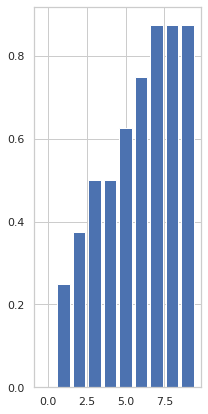

In [72]:
# pltfigsize(3,4)
fig = plt.figure(figsize=(3,7))
# plt.bar(range(10),sorted(low_noise/8))
# plt.bar(range(10),sorted(mid_noise/8))
plt.bar(range(10),sorted(high_noise/8))

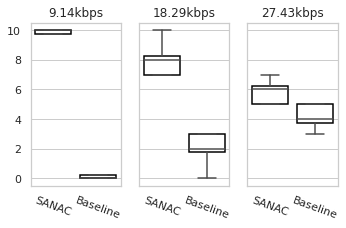

In [75]:
import seaborn as sns

sns.set(style="whitegrid")

f, axes = plt.subplots(1, 3, sharey=True,figsize=(5.5,3))
ax1 = sns.boxplot(data=[low_p, low_b], ax=axes[0],showfliers=False)
ax1.set_title('9.14kbps')
ax1.set_xticklabels(['SANAC', 'Baseline'], rotation=-20)
for i,box in enumerate(ax1.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
    # iterate over whiskers and median lines
#     for j in range(6*i,6*(i+1)):
#          ax.lines[j].set_color('black')
ax2 = sns.boxplot(data=[mid_p,mid_b], ax=axes[1],showfliers=False)
for i,box in enumerate(ax2.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
#     for j in range(6*i,6*(i+1)):
#          ax.lines[j].set_color('black')
ax2.set_title('18.29kbps')
ax2.set_xticklabels(['SANAC', 'Baseline'], rotation=-20)
ax3 = sns.boxplot(data=[high_p,high_b], ax=axes[2],showfliers=False)
for i,box in enumerate(ax3.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
#     for j in range(6*i,6*(i+1)):
#          ax.lines[j].set_color('black')
ax3.set_title('27.43kbps')
ax3.set_xticklabels(['SANAC', 'Baseline'], rotation=-20)

f.savefig('boxplot.pdf', bbox_inches='tight')

In [224]:
tips.shape

NameError: name 'tips' is not defined

{'whiskers': [<matplotlib.lines.Line2D at 0x7f832781fda0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f832782d4e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8327808048>,
 'medians': [<matplotlib.lines.Line2D at 0x7f832782dbe0>,
 'fliers': [],
 'means': []}

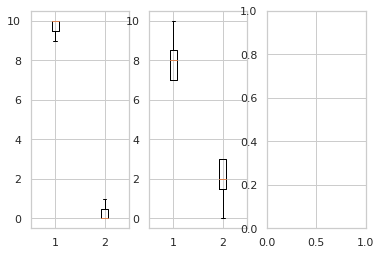

In [212]:
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
ax1.set_title('')
ax1.boxplot([low_p, low_b], showfliers=False, )
ax2.boxplot([mid_p, mid_b], showfliers=False)

## STOI

In [5]:
import soundfile as sf
from pystoi import stoi
import numpy as np
import torch

In [4]:
clean, fs = sf.read('Results/24kbps_prop_1_X.wav')
denoised, fs = sf.read('Results/24kbps_prop_1_Prop.wav')

In [5]:
fs

16000

In [6]:
test_path = 'data/half_win_test_ctn_std_m.pth'
test_loader = torch.load(test_path)

/media/sdb1/hy17/venv/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [6]:
def rebuild(output, overlap = 64):
    output = output.cpu()
    len_wav = len(output) * (512 - overlap) + overlap
    wave = torch.zeros(len_wav)
    for i in range(len(output)):
#         print(i)
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i]       
    
    return wave

def test_stoi(model_prop, model_base):
    
    model_prop.eval()
    model_base.eval()

    stoi_prop = []
    stoi_base = []
    stoi_x = []

    i = 0
    for wave_s, wave_x, source, mixture in test_loader: 

        source = source[0]
        mixture = mixture[0]
        wave_s = wave_s[0].cpu().data.numpy()
        wave_x = wave_x[0].cpu().data.numpy()
        noise = (mixture-source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()
        
        m_prop = model_dict[(db, br, 'prop')]
        m_base = model_dict[(db, br, 'base')]
        model_prop = torch.load(m_prop)
        model_base = torch.load(m_base)
        p_sh, p_nh, _, _ = model_prop(mixture, soft=False)
        b_sh, b_nh, _, _ = model_base(mixture, soft=False)

        p_rs = rebuild(p_sh).unsqueeze(dim = 0)[0].cpu().data.numpy()
        p_rn = rebuild(p_nh).unsqueeze(dim = 0)[0].cpu().data.numpy()
        b_rs = rebuild(b_sh).unsqueeze(dim = 0)[0].cpu().data.numpy()
        b_rn = rebuild(b_nh).unsqueeze(dim = 0)[0].cpu().data.numpy()

#         print(p_rs.shape)
        # d = stoi(clean, denoised, fs, extended=False)
        d_x = stoi(wave_s, wave_x, 16000, extended=False)
        d_prop = stoi(wave_s, p_rs+p_rn, 16000, extended=False)
        d_base = stoi(wave_s, b_rs+b_rn, 16000, extended=False)
        stoi_prop.append(d_prop)
        stoi_base.append(d_base)
        stoi_x.append(d_x)

    stoi_score_p = np.mean(stoi_prop)
    stoi_score_b = np.mean(stoi_base)
    stoi_score_x = np.mean(stoi_x)
    
    return stoi_score_p, stoi_score_b, stoi_score_x

In [19]:


def test_stoi_sp(model_prop, model_base):
    
    model_prop.eval()
    model_base.eval()

    stoi_prop = []
    stoi_base = []
#     stoi_x = []

    i = 0
    for wave_s, wave_x, source, mixture in test_loader: 

        source = source[0]
        mixture = mixture[0]
        wave_s = wave_s[0].cpu().data.numpy()
        wave_x = wave_x[0].cpu().data.numpy()
        noise = (mixture-source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()
        
        m_prop = model_dict[(db, br, 'prop')]
        m_base = model_dict[(db, br, 'base')]
        model_prop = torch.load(m_prop)
        model_base = torch.load(m_base)
        p_sh, p_nh, _, _ = model_prop(mixture, soft=False)
        b_sh, b_nh, _, _ = model_base(mixture, soft=False)

        p_rs = rebuild(p_sh).unsqueeze(dim = 0)[0].cpu().data.numpy()
        p_rn = rebuild(p_nh).unsqueeze(dim = 0)[0].cpu().data.numpy()
        b_rs = rebuild(b_sh).unsqueeze(dim = 0)[0].cpu().data.numpy()
        b_rn = rebuild(b_nh).unsqueeze(dim = 0)[0].cpu().data.numpy()

#         print(p_rs.shape)
        # d = stoi(clean, denoised, fs, extended=False)
#         d_x = stoi(wave_s, wave_x, 16000, extended=False)
        d_prop = stoi(wave_s, p_rs, 16000, extended=False)
        d_base = stoi(wave_s, b_rs, 16000, extended=False)
        stoi_prop.append(d_prop)
        stoi_base.append(d_base)
#         stoi_x.append(d_x)

    stoi_score_p = np.mean(stoi_prop)
    stoi_score_b = np.mean(stoi_base)
#     stoi_score_x = np.mean(stoi_x)
    
    return stoi_score_p, stoi_score_b

In [8]:
# x_0 = []
# prop_0 = []
# base_0 = []
# x_5_mx = []
# prop_5_mx = []
# base_5_mx = []

In [11]:
# for br in [8,16,24,32,40]:
#     db = 0
# #     br = 16
#     # md = 'base'
#     m_prop = model_dict[(db, br, 'prop')]
#     m_base = model_dict[(db, br, 'base')]
#     model_prop = torch.load(m_prop)
#     model_base = torch.load(m_base)
#     p, b, x = test_stoi(model_prop, model_base)
#     x_0.append(x)
#     prop_0.append(p)
#     base_0.append(b)

In [14]:
test_path = 'data/half_win_test_ctn_std4_m.pth'
test_loader = torch.load(test_path)

In [17]:
x_5_mx = []
prop_5_mx = []
base_5_mx = []
for br in [8,16,24]:
    db = 5
#     br = 16
    # md = 'base'
    m_prop = model_dict[(db, br, 'prop')]
    m_base = model_dict[(db, br, 'base')]
    model_prop = torch.load(m_prop)
    model_base = torch.load(m_base)
    p, b, x = test_stoi(model_prop, model_base)
    x_5_mx.append(x)
    prop_5_mx.append(p)
    base_5_mx.append(b)

In [20]:
prop_5_sp = []
base_5_sp = []

for br in [8,16,24]:
    db = 5
#     br = 16
    # md = 'base'
    m_prop = model_dict[(db, br, 'prop')]
    m_base = model_dict[(db, br, 'base')]
    model_prop = torch.load(m_prop)
    model_base = torch.load(m_base)
    p, b = test_stoi_sp(model_prop, model_base)
    prop_5_sp.append(p)
    base_5_sp.append(b)

In [21]:
test_path = 'data/half_win_test_ctn_std_m.pth'
test_loader = torch.load(test_path)

In [22]:
prop_0_sp = []
base_0_sp = []

for br in [8,16,24]:
    db = 0
#     br = 16
    # md = 'base'
    m_prop = model_dict[(db, br, 'prop')]
    m_base = model_dict[(db, br, 'base')]
    model_prop = torch.load(m_prop)
    model_base = torch.load(m_base)
    p, b = test_stoi_sp(model_prop, model_base)
    prop_0_sp.append(p)
    base_0_sp.append(b)

/media/sdb1/hy17/venv/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'Prop.Prop_Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [31]:
prop_0_sp

[0.6837513204665875, 0.733118906651379, 0.8081675401474058]

In [26]:
x_0 = [0.7460180306110448, 0.7460180306110448, 0.7460180306110448,  0.7460180306110447, 0.7460180306110448]
prop_0 = [0.6546403127606605, 0.6676649147135367, 0.723598704968047, 0.7275158491897311, 0.7326819786982817]
base_0 = [0.6236672091878867, 0.6535901371567201, 0.717853202297308, 0.717853202297308, 0.700006973229421]

# x_5 = [0.7460180306110447, 0.7460180306110448, 0.7460180306110447, 0.7460180306110448, 0.7460180306110448]
# prop_5 = [0.6832350252060941, 0.7122132616952211, 0.7209613206303586, 0.7233109211880133, 0.7245117845081619]
# base_5 = [0.6538724320546746, 0.698327963586775, 0.72394389442608, 0.72394389442608, 0.7109217541348511]

In [78]:
x_0_mx = [0.7460180306110448, 0.7460180306110448, 0.7460180306110448]
prop_0_mx = [0.6676649147135367, 0.6546403127606605, 0.723598704968047]
base_0_mx = [0.6236672091878867, 0.6535901371567201, 0.717853202297308]

x_5_mx = [0.8446966476434199, 0.8446966476434199, 0.8446966476434199]
prop_5_mx = [0.7783999112310515, 0.8104198509156268, 0.8170761266924507]
base_5_mx = [0.7298046381804526, 0.7924641132176952, 0.8207261791636372]

prop_0_sp = [0.6837513204665875, 0.733118906651379, 0.8081675401474058]
base_0_sp = [0.6869990980924475, 0.7504386582047214, 0.8335192365465178]

prop_5_sp = [0.8357660714774674, 0.8757873346961882, 0.8761550512673394]
base_5_sp = [0.764555294136213, 0.8445022503079472, 0.8700922046714655]

NameError: name 'x_5' is not defined

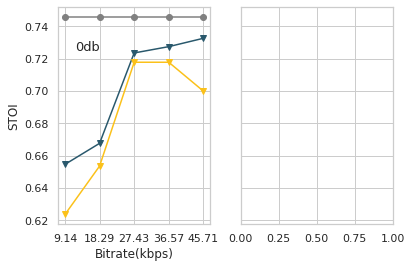

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
# fig1 = plt.subplot(1,2,1, sharey=True)
x_values = ['9.14', '18.29','27.43','36.57','45.71']
x_labels = 'Bitrate(kbps)'
ax1.plot(x_0, label='Ground Truth', color= 'gray', marker='o')
ax1.plot(prop_0, label='Proposed', color='#29586c', marker='v')
ax1.plot(base_0, label='baseline', color='#fbc11a', marker='v')

ax1.set(xlabel=x_labels, ylabel='STOI')
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_xticklabels(x_values)
ax1.text(0.3, 0.725, '0db', fontsize=13)

ax2.plot(x_5, label='Ground Truth', color='grey', marker='o')
ax2.plot(prop_5, label='Proposed', color='#29586c', marker='*')
ax2.plot(base_5, label='baseline', color='#fbc11a', marker='v')

ax2.set(xlabel=x_labels)
ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(x_values)

ax2.legend(loc=4)
ax2.text(0.3, 0.725, '5db', fontsize=13)
# fig2.show()
plt.tight_layout()
fig.savefig('Results/stoi.jpg')
fig.show()

In [36]:
import matplotlib.pyplot as plt

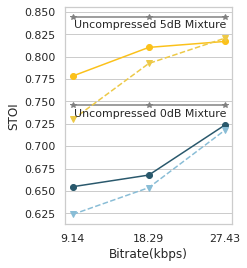

In [79]:
fig, ax1 = plt.subplots(figsize=(3,4))
# fig = plt
ax1.xaxis.grid() # h lines
x_values = ['9.14', '18.29','27.43']
x_labels = 'Bitrate(kbps)'
ax1.plot(x_5_mx, label='Mixtrue', color='grey', marker='*')
ax1.plot(prop_0[:3], label='Proposed 0db', color='#29586c', marker='o')
ax1.plot(base_0[:3], label='Baseline 0db', color='#89bdd6', marker='v', linestyle ='dashed' )
ax1.plot(x_0[:3], color='grey', marker='*')
ax1.plot(prop_5_mx, label='Proposed 5db', color='#fbc11a', marker='o')
ax1.plot(base_5_mx, label='Baseline 5db', color='#EDC946', marker='v',linestyle ='dashed',)


ax1.set(xlabel=x_labels, ylabel='STOI')
ax1.set_xticks([0, 1, 2])
ax1.set_yticks(np.arange(0.625, 0.875, 0.025))
ax1.set_xticklabels(x_values)
# ax.set_xticklabels(x_values)
# ax1.text(0.005, 0.83, 'Mixture', fontsize=12)
ax1.text(0.02, 0.833, 'Uncompressed 5dB Mixture', fontsize=11)
ax1.text(0.02, 0.733, 'Uncompressed 0dB Mixture', fontsize=11)

# # hide x-axis
# ax1.tick_params(axis='x', which='major', top=False, bottom=False, length=0)
# ax1.tick_params(axis='x', which='minor', top=False, bottom=False, length=0)

# ax1.legend(loc='lower right',frameon=False, fontsize=8)
# plt.legend(loc='lower left', bbox_to_anchor =(1.0,0.4,0.6,1.0),
#           frameon=False, mode="expand", ncol=1, fontsize=9)
fig.savefig('stoi_left_34.pdf', bbox_inches='tight')
# ax.show()

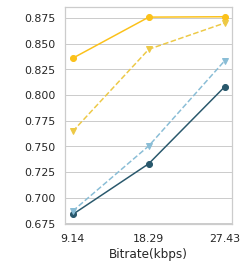

In [80]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(3,4))
# fig = plt
ax.xaxis.grid() # vertical lines
x_sp = [1,1,1]
x_values = ['9.14', '18.29','27.43']
x_labels = 'Bitrate(kbps)'
ax.plot(prop_0_sp, label='Proposed 0db', color='#29586c', marker='o')
ax.plot(base_0_sp, label='Baseline 0db', color='#89bdd6', marker='v', linestyle ='dashed' )
ax.plot(prop_5_sp, label='Proposed 5db', color='#fbc11a', marker='o')
ax.plot(base_5_sp, label='Baseline 5db', color='#EDC946', marker='v',linestyle ='dashed')
# ax.plot(prop_0_sp, label='Proposed 0db', color='#FF9800', marker='o')
# ax.plot(base_0_sp, label='Baseline 0db', color='#FFC100', marker='v',linestyle ='dashed')
# ax.plot(x_sp, label='Original', color='gray', marker='o')

# # hide x-axis
# ax.tick_params(axis='x', which='major', top=False, bottom=False, length=0)
# ax.tick_params(axis='x', which='minor', top=False, bottom=False, length=0)

ax.set(xlabel=x_labels, ylabel=' ')
ax.set_xticks([0, 1, 2])
# ax.set_yticks(np.arange(0.625, 0.90, 0.025))
ax.set_xticklabels(x_values)
# ax.text(0.005, 0.865, 'Speech', fontsize=12)
# ax.legend(frameon=False)
fig.savefig('stoi_right_34.pdf', bbox_inches='tight')
# ax.legend()
# ax.show()

In [ ]:
blue '#29586c', '#89bdd6'
yellow '#fbc11a', '#fade98'

## STOI

In [10]:
import soundfile as sf
from pystoi import stoi
import numpy as np

In [4]:
clean, fs = sf.read('Results/24kbps_prop_1_X.wav')
denoised, fs = sf.read('Results/24kbps_prop_1_Prop.wav')

In [5]:
fs

16000

In [6]:
test_path = 'data/half_win_test_ctn_std_m.pth'
test_loader = torch.load(test_path)

/media/sdb1/hy17/venv/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [7]:
def rebuild(output, overlap = 64):
    output = output.cpu()
    len_wav = len(output) * (512 - overlap) + overlap
    wave = torch.zeros(len_wav)
    for i in range(len(output)):
#         print(i)
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i]       
    
    return wave

def test_stoi(model_prop, model_base):
    
    model_prop.eval()
    model_base.eval()

    stoi_prop = []
    stoi_base = []
    stoi_x = []

    i = 0
    for wave_s, wave_x, source, mixture in test_loader: 

        source = source[0]
        mixture = mixture[0]
        wave_s = wave_s[0].cpu().data.numpy()
        wave_x = wave_x[0].cpu().data.numpy()
        noise = (mixture-source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()
        
        m_prop = model_dict[(db, br, 'prop')]
        m_base = model_dict[(db, br, 'base')]
        model_prop = torch.load(m_prop)
        model_base = torch.load(m_base)
        p_sh, p_nh, _, _ = model_prop(mixture, soft=False)
        b_sh, b_nh, _, _ = model_base(mixture, soft=False)

        p_rs = rebuild(p_sh).unsqueeze(dim = 0)[0].cpu().data.numpy()
        p_rn = rebuild(p_nh).unsqueeze(dim = 0)[0].cpu().data.numpy()
        b_rs = rebuild(b_sh).unsqueeze(dim = 0)[0].cpu().data.numpy()
        b_rn = rebuild(b_nh).unsqueeze(dim = 0)[0].cpu().data.numpy()

#         print(p_rs.shape)
        # d = stoi(clean, denoised, fs, extended=False)
        d_x = stoi(wave_s, wave_x, 16000, extended=False)
        d_prop = stoi(wave_s, p_rs+p_rn, 16000, extended=False)
        d_base = stoi(wave_s, b_rs+b_rn, 16000, extended=False)
        stoi_prop.append(d_prop)
        stoi_base.append(d_base)
        stoi_x.append(d_x)

    stoi_score_p = np.mean(stoi_prop)
    stoi_score_b = np.mean(stoi_base)
    stoi_score_x = np.mean(stoi_x)
    
    return stoi_score_p, stoi_score_b, stoi_score_x

In [8]:
# x_0 = []
# prop_0 = []
# base_0 = []
# x_5 = []
# prop_5 = []
# base_5 = []

In [11]:
# for br in [8,16,24,32,40]:
#     db = 0
# #     br = 16
#     # md = 'base'
#     m_prop = model_dict[(db, br, 'prop')]
#     m_base = model_dict[(db, br, 'base')]
#     model_prop = torch.load(m_prop)
#     model_base = torch.load(m_base)
#     p, b, x = test_stoi(model_prop, model_base)
#     x_0.append(x)
#     prop_0.append(p)
#     base_0.append(b)

In [12]:
# for br in [8,16,24,32,40]:
#     db = 5
# #     br = 16
#     # md = 'base'
#     m_prop = model_dict[(db, br, 'prop')]
#     m_base = model_dict[(db, br, 'base')]
#     model_prop = torch.load(m_prop)
#     model_base = torch.load(m_base)
#     p, b, x = test_stoi(model_prop, model_base)
#     x_5.append(x)
#     prop_5.append(p)
#     base_5.append(b)

In [272]:
x_0_mx = [0.7460180306110448, 0.7460180306110448, 0.7460180306110448,  0.7460180306110447, 0.7460180306110448]
prop_0_mx = [0.6546403127606605, 0.6676649147135367, 0.723598704968047, 0.7275158491897311, 0.7326819786982817]
base_0_mx = [0.6236672091878867, 0.6535901371567201, 0.717853202297308, 0.717853202297308, 0.700006973229421]

x_5_mx = [0.7460180306110447, 0.7460180306110448, 0.7460180306110447, 0.7460180306110448, 0.7460180306110448]
prop_5_mx = [0.6832350252060941, 0.7122132616952211, 0.7209613206303586, 0.7233109211880133, 0.7245117845081619]
base_5_mx = [0.6538724320546746, 0.698327963586775, 0.72394389442608, 0.72394389442608, 0.7109217541348511]

x_0_sp = np.array(x_0_mx) +1
prop_0_sp = np.array(prop_0_mx) +1
base_0_sp = np.array(base_0_mx) +1

x_0_sp = np.array(x_0_mx) +1
prop_0_sp = np.array(prop_0_mx) +1
bse_0_sp = np.array(base_0_mx) +1

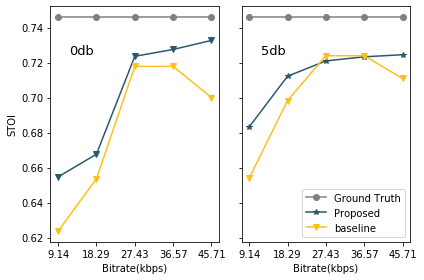

In [78]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
# fig1 = plt.subplot(1,2,1, sharey=True)
x_values = ['9.14', '18.29','27.43','36.57','45.71']
x_labels = 'Bitrate(kbps)'
ax1.plot(x_0, label='Ground Truth', color= 'gray', marker='o')
ax1.plot(prop_0, label='Proposed', color='#29586c', marker='v')
ax1.plot(base_0, label='baseline', color='#fbc11a', marker='v')

ax1.set(xlabel=x_labels, ylabel='STOI')
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_xticklabels(x_values)
ax1.text(0.3, 0.725, '0db', fontsize=13)

ax2.plot(x_5, label='Ground Truth', color='grey', marker='o')
ax2.plot(prop_5, label='Proposed', color='#29586c', marker='*')
ax2.plot(base_5, label='baseline', color='#fbc11a', marker='v')

ax2.set(xlabel=x_labels)
ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(x_values)

ax2.legend(loc=4)
ax2.text(0.3, 0.725, '5db', fontsize=13)
# fig2.show()
plt.tight_layout()
fig.savefig('Results/stoi.jpg')
fig.show()

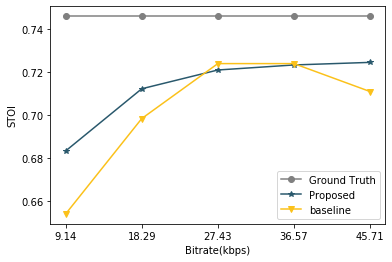

In [39]:
fig = plt
x_values = ['9.14', '18.29','27.43','36.57','45.71']
x_labels = 'Bitrate(kbps)'
fig.plot(x_5, label='Ground Truth', color='grey', marker='*')
fig.plot(prop_5, label='Proposed 5db', color='#F6A229', marker='*')
fig.plot(base_5, label='Baseline 5db', color='#FBD64A', marker='v')
fig.plot(prop_0, label='Proposed 0db', color='#29586c', marker='*')
fig.plot(base_0, label='Baseline 0db', color='#89bdd6', marker='v')

fig.xlabel(x_labels)
fig.ylabel('STOI')
plt.xticks([0, 1, 2, 3, 4], x_values)
fig.legend()
fig.show()

# fig.plot(prop_0_mx, label='proposed 0db mixture', color= '#29586c', marker='o')
# fig.plot(base_0_mx, label='baseline 0db mixture', color= '#89bdd6', linestyle = 'dashed', marker='o')
# fig.plot(np.array(prop_5_mx)-5, label='proposed 5db mixture', color='#F6A229', marker='v')
# fig.plot(np.array(base_5_mx)-5, label='baseline 5db mixture', color='#FBD64A', linestyle ='dashed',marker='v')


In [ ]:
blue '#29586c', '#89bdd6'
yellow '#fbc11a', '#fade98'